![](https://gdmissionsystems.com/-/media/0FFF912023C545F8AC362964AC5D8CD7.ashx)

# Space Communications

Kevin J. Walchko, Phd

25/2/2022

---

Systems Mission and Design (SMAD) is a classic reference for satellite development. In the book, the authors develop a ficticious satellite called FireSat.

## Link Budget Equations

A link budget is the sum and losses in a communications channel between a transmitter and receiver. Generally you want a link budge with at least 3 dB of margin, where

$$
margin = E_b/N_o - E_b/N_o^* - Implementationlosses
$$

where $E_b/N_o$ is defined as the ratio of Energy per Bit ($E_b$) to the Spectral Noise Density ($N_o$), or said another way, is the measure of signal-to-noise for a digital comm system. This measurement is taken at the entrance to the receive aperture. While $E_b/N_o^*$ is the ideal needed for a given modulation format and Bit Error Rate (BER). For the ideal, you can refer to SMAD figure 13-xx.

$$
\begin{align}
E_b/N_o &= \frac {P L_l G_t L_s G_r}{K Ts DR} \\ 
        &= EIRP + L_{pr} + L_s + L_a + (G_r - Ts) - K - DR \\
EIRP &= P L_l G_t \\
P &= 10 \log_{10} P_{TX} \\
Ts &= 10 \log_{10} T_s \\
DR &= 10 \log_{10} dataRate \\
K &= 10 \log_{10} k
\end{align} \\
$$

| Symbol | Unit | Eqn | Definition                                  |
|--------|------|-----|-------------------------------------------------------|
| $L_{pr}$ | dB | 13-21 | Receive antenna pointing loss |
| $L_s$    | dB | 13-23a | Space loss |
| $L_a$    | dB | 13-10 | Propagation and polarization loss |
| $L_l$    | dB |      | Transmitter to antenna line loss |
| $G_r$    | dB | 13-7 | Receive antenna gain (parabolic) |
| $G_t$    | dB | 13-7 | Transmit antenna gain (parabolic) |
| $P_{TX}$ | W  |      | Transmitter power |
| $T_s$    | K  | | System noise temperature
| $K$      | dB | | Boltzman constant $10 \log_{10} k$, where $k$ = 1.38064852 E-23 joule/K |
| $DR$     | bps | | Communications data rate |

$EIRP$ (Effective Isotropically Radiated Power) is descriptive of the transmitter's performance, while $G/T_s$ is a measure of the receiver's sensativity.

## Antenna Theory

A parabolic dish antenna's gain can be calculated from

$$
\lambda = \frac {c}{f} \\
G = 10 \log_{10} \left( \left( \frac{\pi D}{\lambda}  \right)^2 \text{eff} \right)
$$

Next, antennas amplify or antenuate a signal but not in all directions. A plot of an antenna's radiation pattern will display how it effects the RF signal as a function of direction and amplitude (typically in dB).

![](pics/half-power-beamwidth.png)

Half Power Beam Width or HPBW is an angular width (in degrees), measured on the major lobe of an antenna radiation pattern at half-power points i.e the points at which the signal power is half that of its peak value. In other words, The Half Power Beamwidth (HPBW) is the angular separation in which the magnitude of the radiation pattern decreases by 50% (or -3 dB) from the peak of the main beam.

## RF Bands

Band | Wavelengths (cm) | Frequencies
-----|------------------|---------------------------
UHF  | 100 - 10   | 300 - 3000 MHz
L    | 30 - 15    | 1 - 2 GHz
S    | 15 - 7.5   | 2 - 4 GHz
C    | 7.5 - 3.75 | 4 - 8 GHz
X    | 3.75 - 2.4 | 8 - 12 GHz
K    | 2.4 - 0.75 | 12 - 40 GHz
Ku   |            | 15 - 17 GHz
Ka   |            | 20 - 30 GHz

## Data Rate

Channel capacity is given by: $dataRate \leq 2 * BW \cdot log_{2} M$

where M is the bits per symbol.

Modulation | Bits / Symbol
-----------|---------------
BPSK  | 1 bit / symbol
QPSK  | 2 bits / symbol
16QAM | 4 bis / symbol

## deciBels

$$
Attenuation = 10 log_{10} \frac {Power_{in}}{Power_{out}} \text{dB} \\
Attenuation = 20 log_{10} \frac {Voltage_{in}}{Voltage_{out}} \text{dB}
$$

*Note:* $Power = Voltage^2 / R$, the squared voltage is why the second equation is multiplied by 20 and not 10. 

## Tracking, Telemetry, and Command (TT&C)

- USSF SCN: 1.76 - 1.84 GHz UL (L-band), 2.2-2.3 GHz (S-band)
- Unified S-Band: 2025 - 2110 MHz

## Lagrange Points

Lagrange points are interesting locations where gravitational fields between 2 large bodies provide an equilibrium point for small body like a spacecraft. This creates interesting locations where spacecraft can *perch* in a stationary location with respect to the bodies. Below shows the Earth-Moon lagrange points, but there also exists lagrange points for Sun-Earth too that are used by various scientific missions. 

![](pics/eml.jpg)

| Units: km | L1 | L2 | L3 | L4/5 |
|-----------|----|----|----|------|
| Earth-Moon | 326,000 | 448,900 | 381,680 | x |
| Sun-Earth  | x | x | x | x |

*Note:* These distances are measured from Earth's center.

### ARTEMIS

ARTEMIS (Acceleration, Reconnection, Turbulence and Electrodynamics of the Moon’s Interaction with the Sun) P1 spacecraft orbited EML1 and then transitioned to EML2 during its mission. 

<table>
    <tr>
        <td><img src="pics/p1-1.jpg"></td>
        <td><img src="pics/p1-2.jpg"></td>
    </tr>
</table>

## References

- SMAD, third ed., Ch 13
- [Everthing RF](https://www.everythingrf.com/community/what-is-half-power-beam-width)
- [ARTEMIS info](https://space.stackexchange.com/a/4053)

In [1]:
# reload library
%load_ext autoreload
%autoreload 2

In [159]:
from doop.constants import Earth, rad2deg, deg2rad
from doop.constants import EarthMoonLagrange as EML
from doop.constants import speedOfLight as c
import numpy as np
from math import pi, log10, log2
from matplotlib import pyplot as plt
from tqdm import tqdm

EML2 = EML.L2
EML1 = EML.L1

Sband = 2.2e9   # Hz
Xband = 8.5e9   # Hz

In [160]:
def antennaGain(Dia,freq, efficiency=0.7):
    c = 3*10**8 # m/s
    lamda = c/freq # m
    return 10*log10((pi**2 * Dia**2 * efficiency)/lamda**2)

def receivePointingLoss(ptError, halfPwrBW):
    return -12*(ptError/halfPwrBW)**2

def spaceLoss(frequency, distance):
    c = 3*10**8 # m/s
    return 10*log10((c/(4*pi*distance*frequency))**2)

def EbNo(TX, RX, datarate, frequency, distance):
    Ls = spaceLoss(frequency, distance)
    eirp = TX["eirp"]
    
    if "G/T" in RX:
        GT = RX["G/T"]
    else:
        Gr = RX["gain"]
        Ts = RX["sysNoiseTemp"]
        GT = Gr - 10*log10(Ts)
        
    ptErr = RX["pointingError"]
    hpbw = RX["halfPowerBW"]
    Lpr = receivePointingLoss(ptErr, hpbw)
    pp = -0.3
    K = -228.6 # Boltzman const
    ebno = eirp + Lpr + Ls + pp - K + GT - 10*log10(datarate)
    return ebno

## SMAD Firesat

To double check values, let's run the Firesat values and see if we get the same numbers! The goal is to get the same $E_b/N_o$(1) numbers in the link budget below: 45.5 dB and 15.9 dB.

![](pics/smad.png)

### Command Uplink

In [161]:
TX = {
    "eirp": 37.2, # dB
}

RX = {
    "gain": -1.9,        # dB
    "sysNoiseTemp": 614, # K
    "pointingError": 70, # degree
    "halfPowerBW": 150   # degree
}

EbNo(TX, RX, 100, 2e9, 2831e3)

45.60381346862464

### Mission Data Downlink

In [162]:
TX = {
    "eirp": 17.7, # dB
}

RX = {
    "gain": 39,           # dB
    "sysNoiseTemp": 135,  # K
    "pointingError": 0.2, # degree
    "halfPowerBW": 1.8    # degree
}

EbNo(TX, RX, 85e6, 2.2e9, 2831e3)

15.925301719963983

# ARTEMIS

Let's play with some other values around EML1/2 like NASA's ARTEMIS mission. I don't know what communications system they used or what their specs were, so I will just assume something.

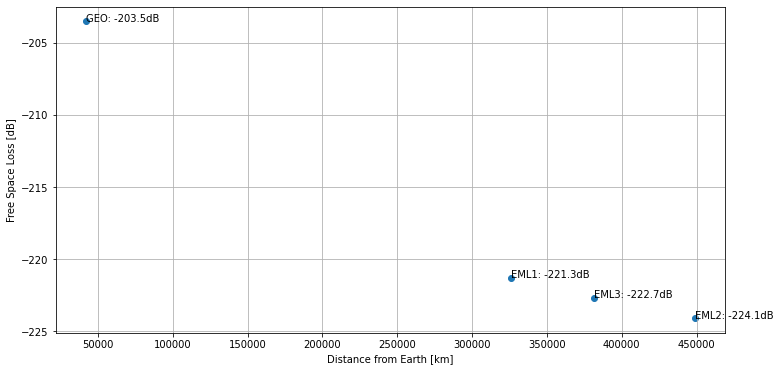

In [163]:
# Usually, people think geostationary is far away, but
# Lagrange points are even farther out and you pay a
# higher penalty in free space losses
GEO = 42164e3 # m
spLoss = []
LP = np.array([GEO, EML.L1, EML.L2, EML.L3])
for d in LP:
    l = spaceLoss(Xband, d)
    spLoss.append(l)

LP = LP/1E3
plt.figure(figsize=(12,6))
plt.scatter(LP, spLoss)
for i, label in enumerate(["GEO","EML1","EML2","EML3"]):
    label += f": {spLoss[i]:.1f}dB"
    plt.annotate(label, (LP[i], spLoss[i]))
plt.grid(True)
plt.ylabel("Free Space Loss [dB]")
plt.xlabel("Distance from Earth [km]");

In [164]:
# Assume this 
ebno = 10.4 # dB, this is for a BER 1E-6 and BPSK modulation

In [165]:
# This determines Eb/No for a given data rate, frequency band, and location
#
def run(datarate, band, loc):
    Sband = 2.2e9   # Hz
    Xband = 8.5e9   # Hz
    
    satPoitingError = 5       # degree
    
    groundPointingError = 0.2 # degree
    groundHPBW = 1.8          # degree
    
    if loc not in [EML.L1, EML.L2]:
        raise Exception(f"Invalid location: {loc}")
    
    if band == Sband:
        # Up ---------------------------------------------------
        uTX = {
            "eirp": 68, # dB
        }

        uRX = {
            "gain": -4.5,        # dB
            "sysNoiseTemp": 614, # K
            "pointingError": satPoitingError, # degree
            "halfPowerBW": 150   # degree
        }
        # Down ----------------------------------------------------
        Gt = -2.9       # dB
        Ll = -1         # dB
        P = 10*log10(5) # dBW
        eirp = Gt+Ll+P
        
        dTX = {
            "eirp": eirp, # dB
        }

        dRX = {
            "G/T": 37.7,
            "pointingError": groundPointingError,
            "halfPowerBW": groundHPBW
        }
        
    elif band == Xband:
        # Up ---------------------------------------------------
        # parabolic high gain directional antenna
        Dia = 1 # m
        Gt = antennaGain(Dia, band) # dB

        uTX = {
            "eirp": 68, # dB
        }

        uRX = {
            "gain": Gt,        # dB
            "sysNoiseTemp": 614, # K
            "pointingError": satPoitingError, # degree
            "halfPowerBW": 5   # degree
        }
        # Down ----------------------------------------------------
        lineLoss = -1     # dB
        Pwr = 3.5         # W
        P = 10*log10(Pwr) # dBW
        eirp = Gt+P+lineLoss

        dTX = {
            "eirp": eirp, # dB
        }

        dRX = {
            "G/T": 37.7,
            "pointingError": groundPointingError,
            "halfPowerBW": groundHPBW
        }
        
    else:
        raise Exception(f"Invalid comm band: {band}")

    enup = EbNo(uTX, uRX, datarate, band, loc)
    endown = EbNo(dTX, dRX, datarate, band, loc)

    return enup, endown

### S-Band Patch Antenna

This assumes a simple patch antenna with a low gain and wide beam pattern.

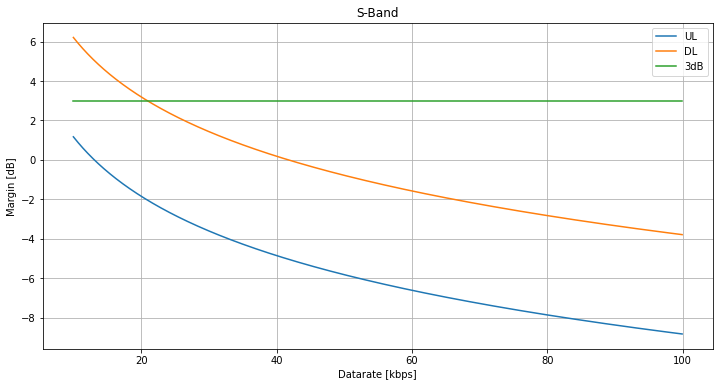

In [166]:
rates = np.arange(10e3,100e3,100) # S-band rates
eup = []
edown = []
for dr in rates:
    u,d = run(dr, Sband, EML2)
    eup.append(u-ebno)
    edown.append(d-ebno)
    
plt.figure(figsize=(12,6))
plt.plot(rates/1e3, eup, label="UL")
plt.plot(rates/1e3, edown, label="DL")
plt.plot(rates/1e3, 3*np.ones(len(rates)), label="3dB")
plt.grid(True)
plt.xlabel("Datarate [kbps]")
plt.ylabel("Margin [dB]")
plt.title("S-Band")
plt.legend();

### X-Band Directional

The assumes a directional (probably deployable) antenna with a high gain and narrow beam pattern.

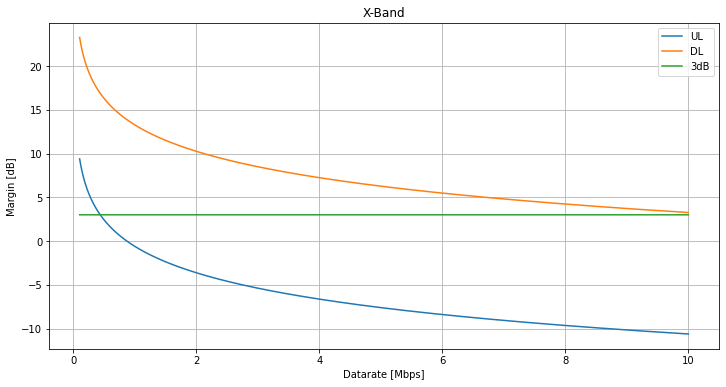

In [167]:
rates = np.arange(100e3,10e6,100) # X-band rates
eup = []
edown = []
for dr in rates:
    u,d = run(dr, Xband, EML2)
    eup.append(u-ebno)
    edown.append(d-ebno)
    
plt.figure(figsize=(12,6))
plt.plot(rates/1e6, eup, label="UL")
plt.plot(rates/1e6, edown, label="DL")
plt.plot(rates/1e6, 3*np.ones(len(rates)), label="3dB")
plt.grid(True)
plt.xlabel("Datarate [Mbps]")
plt.ylabel("Margin [dB]")
plt.title("X-Band")
plt.legend();

In [137]:
Gt = -2.9       # dB
Ll = -1         # dB
P = 10*log10(5) # dBW
eirp = Gt+Ll+P
eirp

3.0897000433601884

## Calculating Bit Error Rate (BER)

For BPSK the BER is:

$$
\DeclareMathOperator\erf{erfc}
BER = \frac{1}{2} erfc \left( \sqrt{\frac{E_b}{N_o}} \right)
$$

- [BPSK bit error rate simulation in Python & Matlab](https://www.gaussianwaves.com/2020/07/bpsk-python-matlab-bit-error-rate-simulation/)
- [BPSK Bit Error Rate Calculation Using Python](http://www.raymaps.com/index.php/bpsk-bit-error-rate-calculation-using-python/)

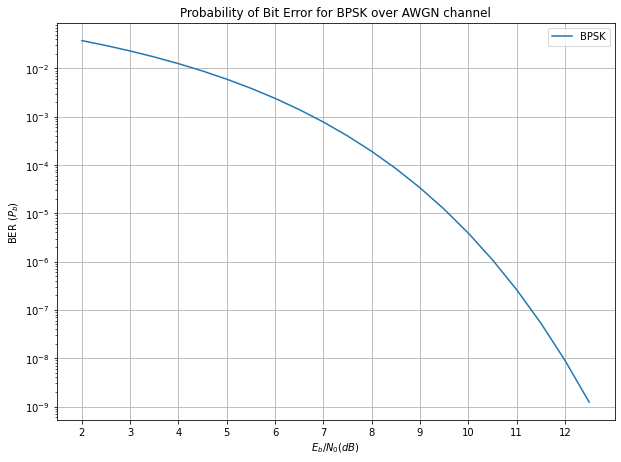

In [69]:
#Eb/N0 Vs BER for BPSK over AWGN (complex baseband model)
# © Author: Mathuranathan Viswanathan (gaussianwaves.com)
# https://www.gaussianwaves.com/2020/07/bpsk-python-matlab-bit-error-rate-simulation/
from scipy.special import erfc # erfc/Q function

# Eb/N0 range in dB for simulation
ebnoStart = 2
ebnoStop = 13
EbN0dBs = np.arange(start=ebnoStart,stop = ebnoStop, step = .5)

# fix x-axis
ticks = np.arange(ebnoStart,ebnoStop, 1)

BER_theory = 0.5*erfc(np.sqrt(10**(EbN0dBs/10)))

fig, ax = plt.subplots(nrows=1,ncols = 1, figsize=(10,10))
fig.figsize = (200,10)
ax.semilogy(EbN0dBs,BER_theory,marker='',linestyle='-',label='BPSK')
ax.set_xlabel('$E_b/N_0(dB)$');
ax.set_ylabel('BER ($P_b$)')
ax.set_title('Probability of Bit Error for BPSK over AWGN channel')
ax.set_aspect('equal')
ax.set_xticks(ticks)
ax.grid(True)
ax.legend();

100%|███████████████████████████████████████████| 12/12 [00:03<00:00,  3.84it/s]


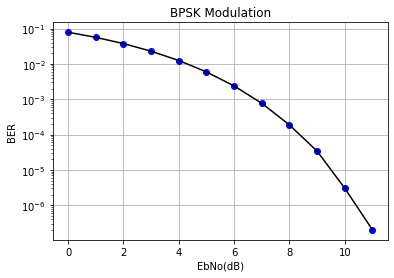

In [66]:
from numpy import sqrt
from numpy.random import rand, randn

N = 5000000
EbNodB_range = range(0,12)
ber = []

for EbNodB in tqdm(EbNodB_range):
    EbNo=10.0**(EbNodB/10.0)
    x = 2 * (rand(N) >= 0.5) - 1
    noise_std = 1/sqrt(2*EbNo)
    y = x + noise_std * randn(N)
    y_d = 2 * (y >= 0) - 1
    errors = (x != y_d).sum()
    ber_n = 1.0 * errors / N
    ber.append(ber_n)
    
    # print ("EbNodB:", EbNodB,"  Error bits:", errors,"  Error probability:", ber[n] )
    
plt.plot(EbNodB_range, ber, 'bo', EbNodB_range, ber, 'k')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('EbNo(dB)')
plt.ylabel('BER')
plt.grid(True)
plt.title('BPSK Modulation');

In [123]:
# help(ax.scatter)